In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [3]:
dfs5 = pd.read_csv('Data/Solar Data/Solar 5.csv')

In [4]:
dfs5

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,0,0.00,2019-01-15 13:00:00,2019,1,15,13,0,Solar5
1,4,0.00,2019-01-15 14:00:00,2019,1,15,14,0,Solar5
2,8,0.00,2019-01-15 15:00:00,2019,1,15,15,0,Solar5
3,12,0.00,2019-01-15 16:00:00,2019,1,15,16,0,Solar5
4,16,0.00,2019-01-15 17:00:00,2019,1,15,17,0,Solar5
...,...,...,...,...,...,...,...,...,...
15726,62904,0.01,2020-10-31 19:00:00,2020,10,31,19,0,Solar5
15727,62908,1.16,2020-10-31 20:00:00,2020,10,31,20,0,Solar5
15728,62912,3.49,2020-10-31 21:00:00,2020,10,31,21,0,Solar5
15729,62916,6.53,2020-10-31 22:00:00,2020,10,31,22,0,Solar5


In [9]:
data = dfs5['series_value'][7000:8000]

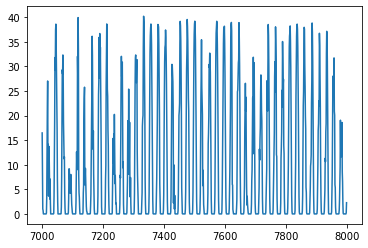

In [10]:
plt.plot(data)

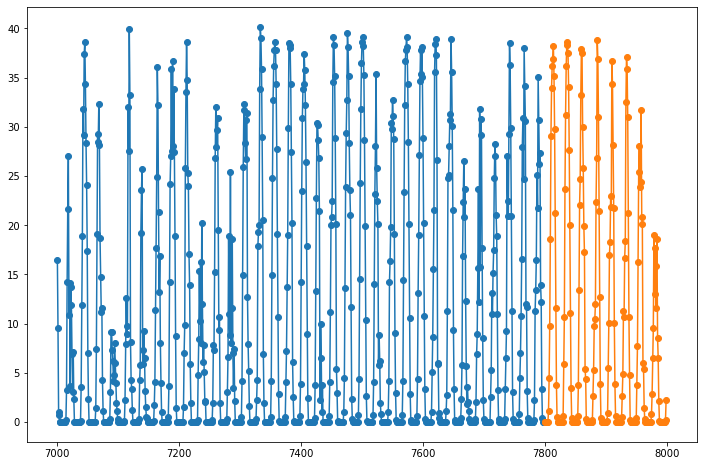

In [11]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [12]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -2311.564
Date:                Wed, 28 Sep 2022   AIC                           4639.128
Time:                        18:25:47   BIC                           4676.605
Sample:                             0   HQIC                          4653.525
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5417      0.183      2.964      0.003       0.184       0.900
ar.L1          1.8478      0.078     23.719      0.000       1.695       2.000
ar.L2         -0.7930      0.089     -8.883      0.000      -0.968      -0.618
ar.L3         -0.1868      0.049     -3.829      0.000      -0.282      -0.091
ar.L4          0.0190      0.047      0.403      0.687      -0.074       0.112
ar.L5          0.0569      0.037      1.555      0.120      -0.015       0.129
ma.L1         -0.8482      0.068    -12.499      0.000      -0.981      -0.715
sigma2        18.8676      0.668     28.235      0.000      17.558      20.177
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               603.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.10
Prob(H) (two-sided):                  0.19   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
data = train
# define model
my_order = (5, 1, 1)
my_seasonal_order = (5, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

In [15]:
yhat

7000     0.000000
7001    16.459959
7002     9.520039
7003     1.020030
7004     0.699971
          ...    
7196    -0.879309
7197    -1.091462
7198    -0.231820
7199     0.317661
7200     0.339994
Name: predicted_mean, Length: 201, dtype: float64

In [24]:
lst = []
for i in range(7010, 7201):
    lst.append(yhat[i])

In [25]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [18]:
test

7800    0.00
7801    0.00
7802    0.00
7803    0.00
7804    0.00
        ... 
7995    0.00
7996    0.00
7997    0.00
7998    0.24
7999    2.28
Name: series_value, Length: 200, dtype: float64

In [27]:
lst = []
for i in range(7800, 7990):
    lst.append(test[i])

In [28]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

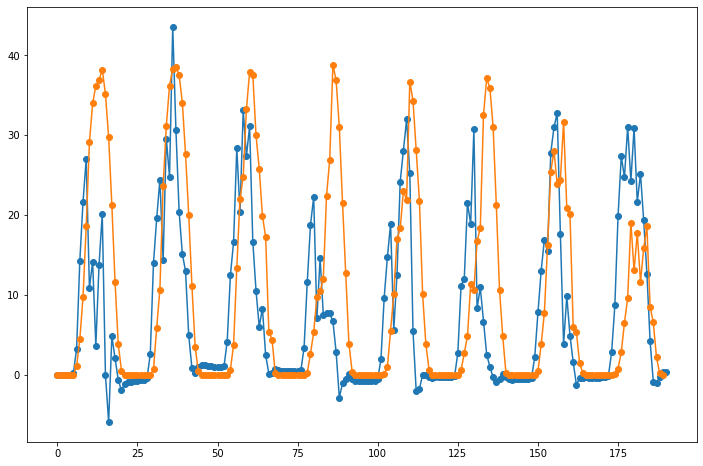

In [29]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [30]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

2.4989052397324873